## Showing Violations

In [27]:
import json
import torch
import numpy as np
from config import CommittorNet
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
with open('rates_db.json') as f:
    data = json.load(f)

In [2]:
print(data.keys())

dict_keys(['wells_triangle_2_a0_b1', 'wells_triangle_3_a0_b1', 'wells_linear_3_a0_b1', 'wells_linear_3_a0_b2', 'wells_linear_5_a0_b3', 'wells_linear_5_a0_b2', 'wells_linear_5_a0_b1'])


In [8]:
print(data["wells_linear_3_a0_b1"][-1])
print(data["wells_linear_3_a0_b2"][-1])
print(data["wells_linear_5_a0_b1"][-1])
print(data["wells_linear_5_a0_b2"][-1])
print(data["wells_linear_5_a0_b3"][-1])

[0.00023165160332202307, 0.0002152709752008934]
[0.0001405894152791973, 0.00014555607193550484]
[0.00022269580429685676, 0.000286812910574657]
[5.273684838284412e-05, 0.00047521608950889507]
[2.57864287213215e-06, 9.052893874355336e-05]


In [68]:
running_xs = torch.load("run_data/wells_linear_5_a0_b3_rxs.pt").to(torch.float32)
model = CommittorNet(dim=2)
model.load_state_dict(torch.load("run_data/wells_linear_5_a0_b3.pt", map_location='cpu'))
model.eval()

# Run inference
with torch.no_grad():
    q_nn = torch.sigmoid(model(running_xs)).cpu().numpy().reshape([-1,1])
running_xs = running_xs.cpu().numpy()

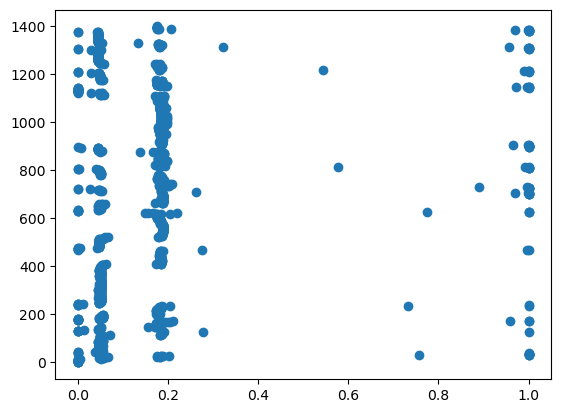

In [69]:
plt.scatter(q_nn,np.arange(q_nn.shape[0]))

(1400, 1)

In [71]:
db = DBSCAN(eps=0.05, min_samples=10)
labels = db.fit_predict(q_nn)

# Identify core samples, noise
core_samples = db.core_sample_indices_
unique_labels = set(labels)
colors = plt.cm.get_cmap('tab10', len(unique_labels))
print(unique_labels)

{0, 1, 2, -1}


/tmp/ipykernel_147231/3525860764.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


In [72]:
labels

array([0, 0, 0, ..., 1, 1, 1])

0 0.042196993
1 0.18364647
2 0.9967228


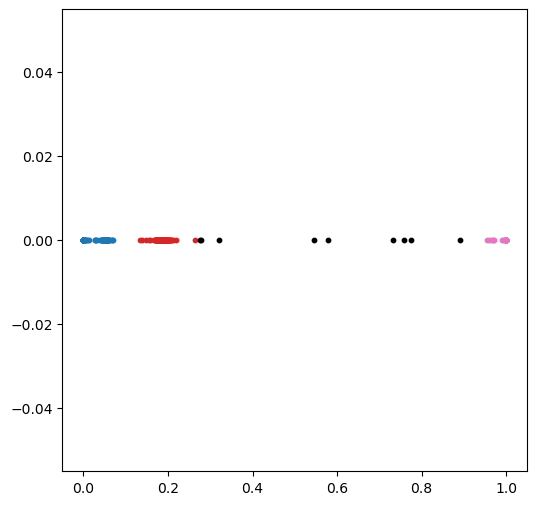

In [73]:
plt.figure(figsize=(6,6))
for k in unique_labels:
    class_member_mask = (labels == k)
    xy = q_nn[class_member_mask]
    if k == -1:
        # Noise
        plt.scatter(xy, np.zeros_like(xy), c='k', s=10, label='noise')
    else:
        print(k,np.mean(xy))
        plt.scatter(xy, np.zeros_like(xy), c=[colors(k)], s=10, label=f'cluster {k}')

I need to handle the case where split between very close, disjointed groups at same q value

In [74]:
print(running_xs.shape,q_nn.shape)

(1400, 2) (1400, 1)


In [75]:
xs_qnn = np.hstack([running_xs,q_nn])

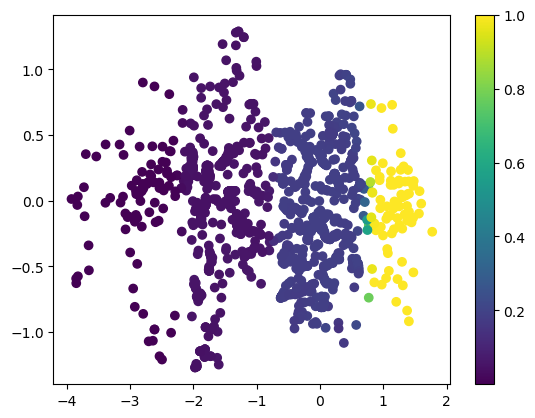

In [100]:
plt.scatter(xs_qnn[:,0], xs_qnn[:,1], c=xs_qnn[:,2])
plt.colorbar()
plt.show()

In [110]:
labels1 = DBSCAN(eps=0.05,min_samples=10).fit_predict(xs_qnn[:, -1].reshape(-1, 1))
classes1 = set(labels1)
classes1_means = [np.mean(xs_qnn[(labels1 == lbl),-1]) for lbl in classes1 if lbl != -1]
print(classes1, classes1_means)

{0, 1, 2, -1} [0.042196993, 0.18364647, 0.9967228]


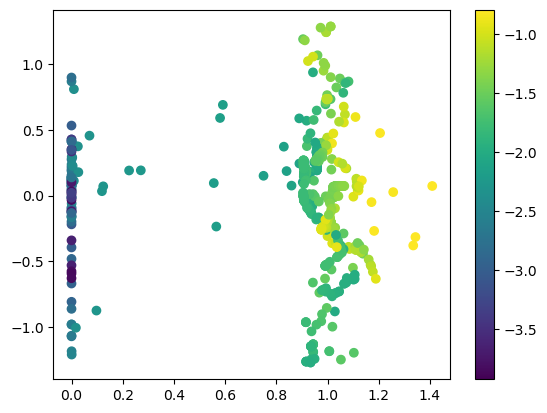

0 {0, 1, -1}


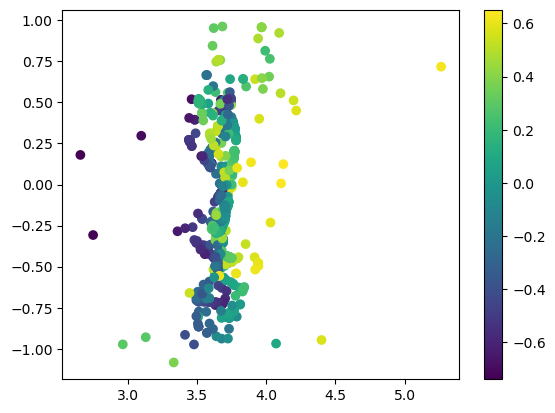

1 {0, -1}


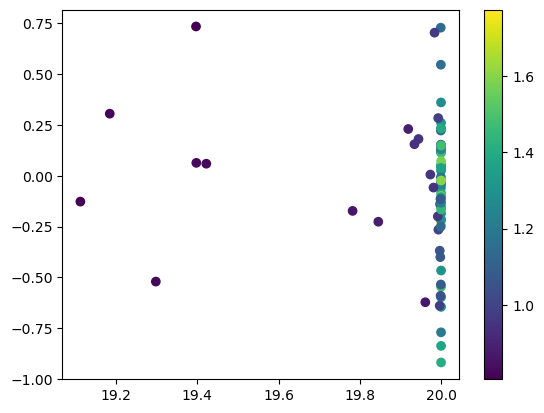

2 {0, -1}


In [117]:
results = {}
for lbl in classes1:
    if lbl == -1:
        continue
    mask = labels1 == lbl

    data = xs_qnn[mask]
    feats = np.concatenate([data[:, :-1], (data[:, -1] * 20).reshape(-1, 1)], axis=1)
    plt.scatter(feats[:,2],feats[:,1],c=feats[:,0])
    plt.colorbar()
    plt.show()
    labels2 = DBSCAN(eps=0.4, min_samples=10).fit_predict(feats)
    results[lbl] = labels2
    print(lbl, set(labels2))
    # print(lbl,labels2)

eh it's fiddly, just make epsilon = .02